<a href="https://colab.research.google.com/github/masataka715/jupyter_notebook_playground/blob/master/cifar10_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

In [ ]:
# GPU が使用可能であることを確認
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9771414105756611357
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8251451558515461144
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13703323140844509013
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3324158463573536839
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [2]:
train, test = tf.keras.datasets.cifar10.load_data()
# 画像の情報
train[0].shape, test[0].shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
# ラベルの情報
train[1].shape, test[1].shape

((50000, 1), (10000, 1))

In [ ]:
# 学習用データセットとテスト用データセットに対して正規化
x_train = train[0] / 255
x_test = test[0] / 255

# 目標値の切り分け
t_train = train[1]
t_test = test[1]

In [ ]:
# 32bit にキャスト
x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
t_train, t_test = t_train.astype('int32'), t_test.astype('int32')

In [3]:
import os, random

def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [ ]:
from tensorflow.keras import models,layers

# シードの固定
reset_seed(0)

# モデルの構築
model = models.Sequential([
    # 特徴量抽出
    layers.Conv2D(filters=3, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPool2D(pool_size=(2, 2)),
    # ベクトル化
    layers.Flatten(),
    # 識別
    layers.Dense(100, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 3)         84        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 675)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               67600     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 68,694
Trainable params: 68,694
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 4096
epochs = 30
history = model.fit(x_train, t_train,
                batch_size=batch_size,
                epochs=epochs, 
                validation_data=(x_test, t_test))

Epoch 1/30
13/13 [==============================] - 1s 65ms/step - loss: 2.1485 - accuracy: 0.2161 - val_loss: 1.9056 - val_accuracy: 0.3299
Epoch 2/30
13/13 [==============================] - 0s 35ms/step - loss: 1.8597 - accuracy: 0.3517 - val_loss: 1.7646 - val_accuracy: 0.3812
Epoch 3/30
13/13 [==============================] - 0s 34ms/step - loss: 1.6794 - accuracy: 0.4031 - val_loss: 1.6413 - val_accuracy: 0.4124
Epoch 4/30
13/13 [==============================] - 0s 36ms/step - loss: 1.5723 - accuracy: 0.4380 - val_loss: 1.5561 - val_accuracy: 0.4422
Epoch 5/30
13/13 [==============================] - 0s 35ms/step - loss: 1.4943 - accuracy: 0.4659 - val_loss: 1.5116 - val_accuracy: 0.4553
Epoch 6/30
13/13 [==============================] - 0s 34ms/step - loss: 1.4458 - accuracy: 0.4834 - val_loss: 1.4698 - val_accuracy: 0.4743
Epoch 7/30
13/13 [==============================] - 0s 36ms/step - loss: 1.4010 - accuracy: 0.5017 - val_loss: 1.4626 - val_accuracy: 0.4777
Epoch 8/30
13

In [ ]:
!nvidia-smi

Wed Oct 28 05:33:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    34W /  70W |   1383MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
results = pd.DataFrame(history.history)
results.tail(3)

,loss,accuracy,val_loss,val_accuracy
27,0.952864,0.66762,1.444254,0.5187
28,0.942548,0.67206,1.470357,0.5093
29,0.941037,0.67172,1.481043,0.5151


In [4]:
from tensorflow.keras.applications import resnet, VGG16

# 学習済みモデルVGG16をインスタンス化
# VGG16 では画像サイズ (224, 224, 3) の画像で事前学習されている
# include_top=False 事前学習済みの全結合層を除く(ImageNet では 1000 クラス分類ですが、今回は 10 クラス分類なので最終層に全結合層を自分の問題設定に合うように追加)
# weights='imagenet' 事前学習済みの重みを引き継ぐ
base_model = VGG16(input_shape=(224, 224, 3),
                                      include_top=False, weights='imagenet')
      
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
# データが多いので、ランダムにデータを取得する
train_choice = np.random.randint(low=0, high=50000, size=5000)
test_choice = np.random.randint(low=0, high=10000, size=2500)

In [6]:
x_train = train[0][train_choice]
x_test = test[0][test_choice]
t_train = train[1][train_choice].astype('int32') 
t_test = test[1][test_choice].astype('int32') 

In [7]:
#画像のサイズ(32, 32, 3)をVGG16の学習サイズ(224, 224, 3)に大きくする
_train, _test = [], []
for img in x_train:
    _train.append(cv2.resize(src=img, dsize=(224, 224)))
for img in x_test:    
    _test.append(cv2.resize(src=img, dsize=(224, 224)))


In [8]:
# リストから ndarray に変換し、正規化
x_train = np.array(_train, dtype='float32') / 255.0
x_test = np.array(_test, dtype='float32') / 255.0
x_train.shape, x_test.shape

((5000, 224, 224, 3), (2500, 224, 224, 3))

In [9]:
from tensorflow.keras import models,layers

reset_seed(0)

# 全結合層の追加
# Flattenの代わりに、GlobalAveragePooling2Dを使う（学習すべきパラメータ数を減らすため）
finetuned_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [10]:
optimizer = tf.keras.optimizers.SGD(lr=0.01)
finetuned_model.compile(optimizer=optimizer,
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])
finetuned_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 14,982,474
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 学習前の正解率(10%)
loss, accuracy = finetuned_model.evaluate(x_test, t_test)

79/79 [==============================] - 9s 116ms/step - loss: 2.4383 - accuracy: 0.1008


In [12]:
print(f'loss : {loss}, acuracy : {accuracy}')

loss : 2.4382503032684326, acuracy : 0.10080000013113022


In [13]:
history = finetuned_model.fit(x_train, t_train, 
                    epochs=10, 
                    batch_size=32,
                    validation_data=(x_test, t_test))

Epoch 1/10
157/157 [==============================] - 75s 479ms/step - loss: 2.2088 - accuracy: 0.1820 - val_loss: 2.8492 - val_accuracy: 0.1568
Epoch 2/10
157/157 [==============================] - 80s 507ms/step - loss: 1.8073 - accuracy: 0.3498 - val_loss: 2.5662 - val_accuracy: 0.1700
Epoch 3/10
157/157 [==============================] - 79s 505ms/step - loss: 1.6276 - accuracy: 0.4216 - val_loss: 1.5222 - val_accuracy: 0.4448
Epoch 4/10
157/157 [==============================] - 79s 505ms/step - loss: 1.2044 - accuracy: 0.5794 - val_loss: 1.4089 - val_accuracy: 0.5036
Epoch 5/10
157/157 [==============================] - 80s 508ms/step - loss: 1.0880 - accuracy: 0.6290 - val_loss: 1.7224 - val_accuracy: 0.4820
Epoch 6/10
157/157 [==============================] - 80s 510ms/step - loss: 0.8895 - accuracy: 0.6904 - val_loss: 1.2624 - val_accuracy: 0.5916
Epoch 7/10
157/157 [==============================] - 80s 509ms/step - loss: 0.8031 - accuracy: 0.7206 - val_loss: 1.0549 - val_ac

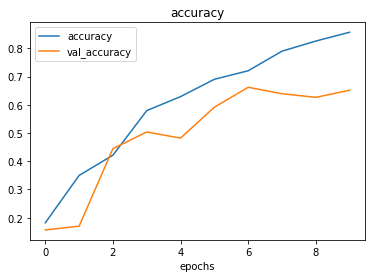

In [15]:
学習後の正解率85%
results = pd.DataFrame(history.history)
results[['accuracy', 'val_accuracy']].plot(title='accuracy')
plt.xlabel('epochs');